# Project Advanced Lane Lines

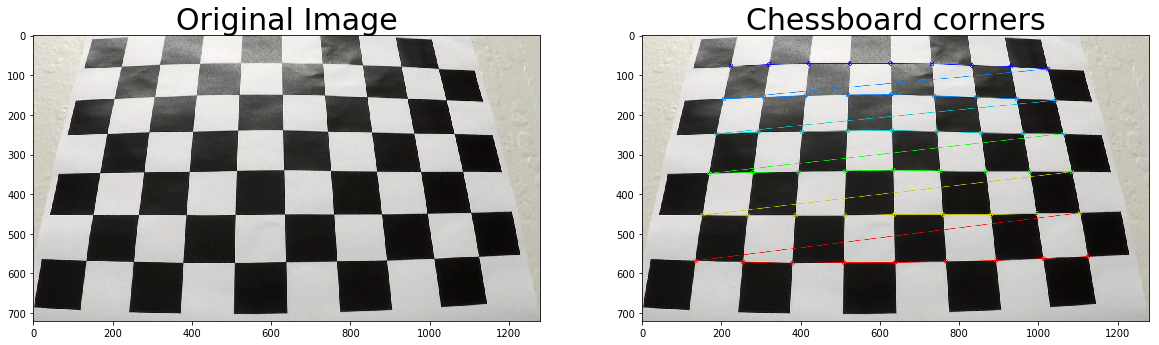

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread ('camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
img_corners = np.copy(img)
cv2.drawChessboardCorners(img_corners, (9,6), corners, ret)

# Visualize chessboard corners
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corners)
ax2.set_title('Chessboard corners', fontsize=30)

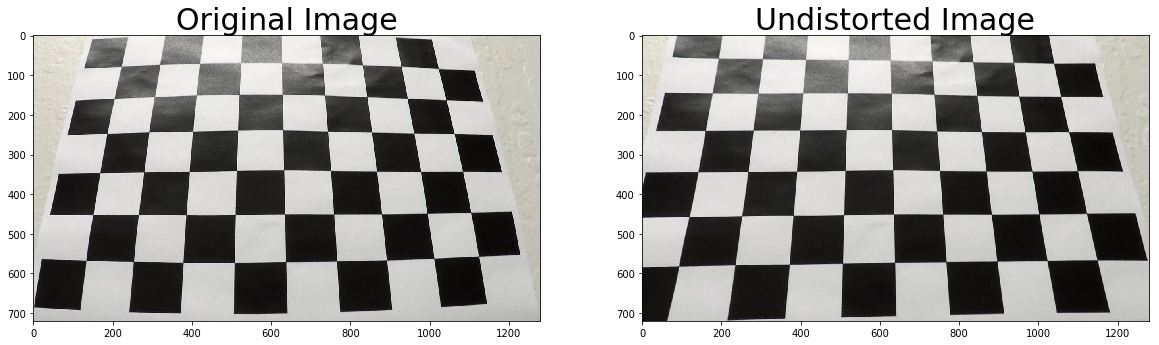

In [2]:
# Test undistortion on an image
img = mpimg.imread ('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

def calibrate_camera(img_size):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list of calibration images and find chessboard corners
    for i in range(20):
        fname = 'camera_cal/calibration'+str(i+1)+'.jpg'
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera(img_size)
dst = cv2.undistort(img, mtx, dist, None, mtx)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

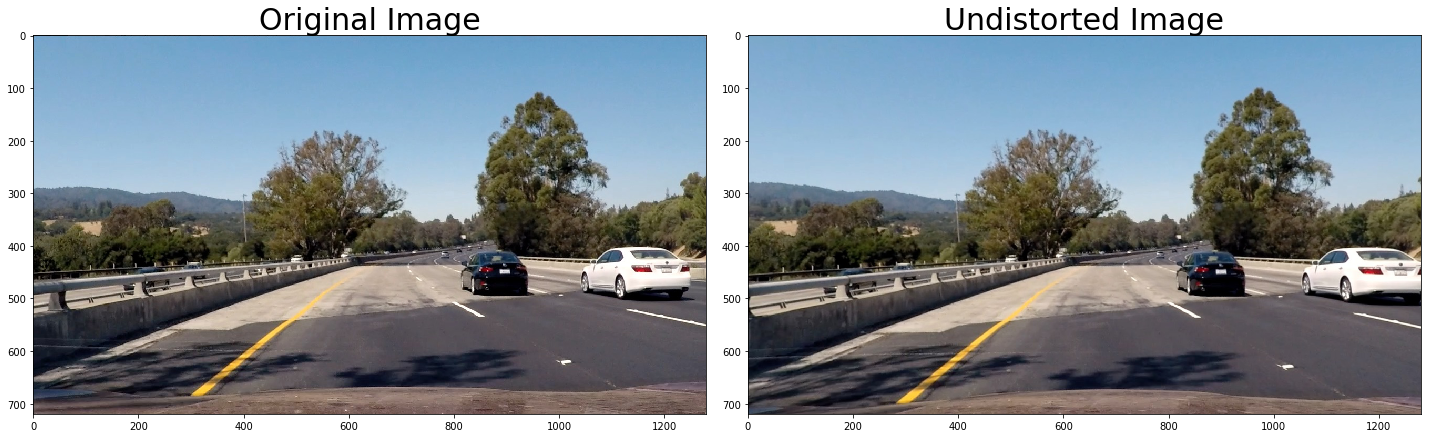

In [3]:
# Test undistortion on an image
img = mpimg.imread ('test_images/test4.jpg')
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

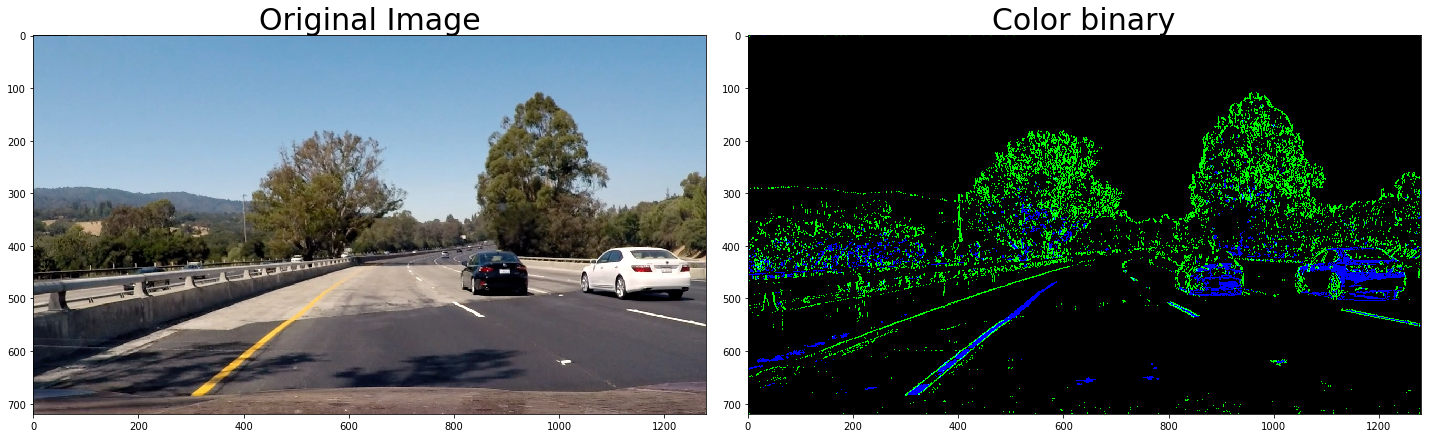

In [4]:
#use a combination of color and gradient thresholds to generate a binary image
img = mpimg.imread ('test_images/test4.jpg')

def get_color_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):

    img = np.copy (img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel (l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack ((np.zeros_like (sxbinary), sxbinary, s_binary))
    return color_binary

color_binary = get_color_binary(img)

# Plot the result
f, (ax1, ax2) = plt.subplots (1, 2, figsize=(20, 10))
f.tight_layout ()
ax1.imshow (img)
ax1.set_title ('Original Image', fontsize=30)
ax2.imshow (color_binary)
ax2.set_title ('Color binary', fontsize=30)

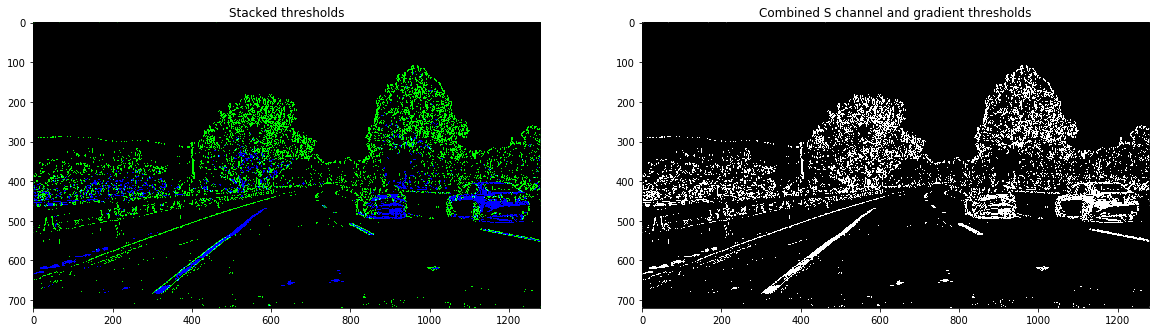

In [5]:
def get_combined_binary(color_binary):
    # Combine the two binary thresholds
    sxbinary = color_binary[:,:,1]
    s_binary = color_binary[:,:,2]
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

combined_binary = get_combined_binary(color_binary)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

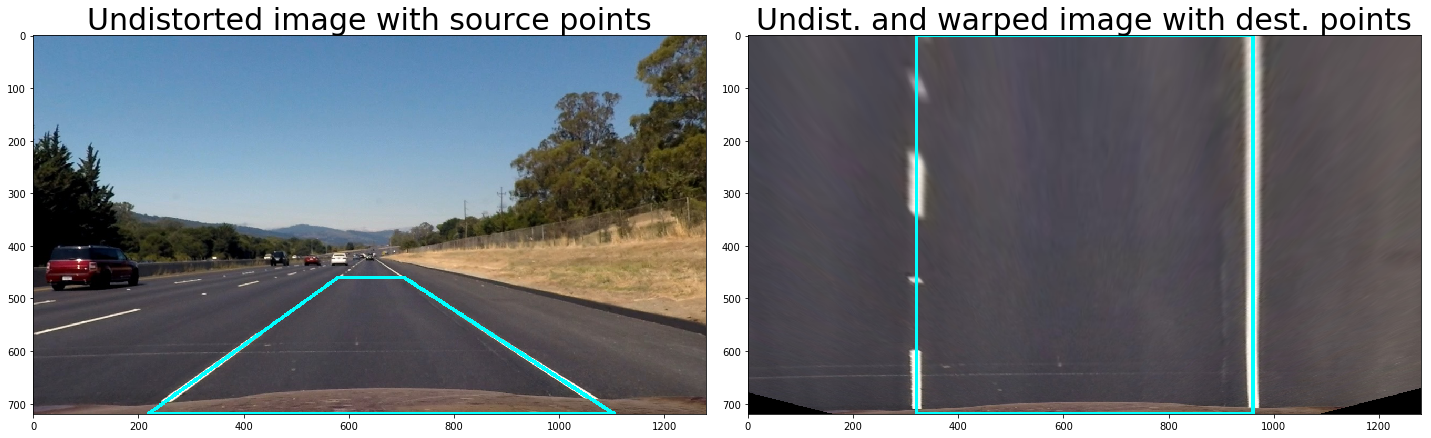

In [6]:
img = mpimg.imread ('test_images/straight_lines2.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)

src_pts = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 5), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst_pts = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

#plot source points on undistorted image
undist_src_pts = np.copy(undist)
src_pts_int = np.int32(src_pts)
src_pts_int = src_pts_int.reshape((-1,1,2))
cv2.polylines(undist_src_pts,[src_pts_int],True,(0,255,255), thickness=5)

def warp(img, src_pts, dst_pts):
     # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)

    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# tranform perspective
top_down, perspective_M, perspective_Minv = warp(undist, src_pts, dst_pts)

#plot destination points on warped image
dst_pts_int = np.int32(dst_pts)
dst_pts_int = dst_pts_int.reshape((-1,1,2))
cv2.polylines(top_down,[dst_pts_int],True,(0,255,255), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(undist_src_pts)
ax1.set_title('Undistorted image with source points', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Undist. and warped image with dest. points', fontsize=30)


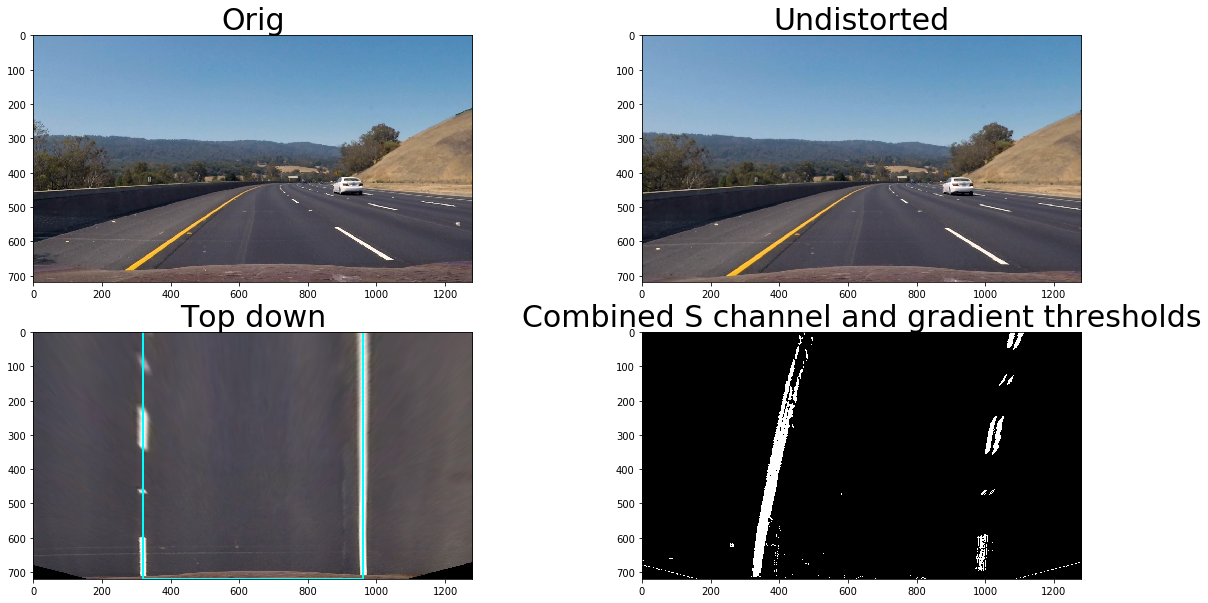

In [7]:
img = mpimg.imread ('test_images/test3.jpg')

def get_warped_binary(img, mtx, dist, src_pts, dst_pts):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    top_down, perspective_M, perspective_Minv = warp(undist, src_pts, dst_pts)
    color_binary = get_color_binary(top_down)
    binary_warped = get_combined_binary(color_binary)
    return (binary_warped, undist)

binary_warped, undist = get_warped_binary(img, mtx, dist, src_pts, dst_pts)

f, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0,0].set_title('Orig', fontsize=30)
axes[0,0].imshow(img)
axes[0,1].set_title('Undistorted', fontsize=30)
axes[0,1].imshow(undist)
axes[1,0].set_title('Top down', fontsize=30)
axes[1,0].imshow(top_down)
axes[1,1].set_title('Combined S channel and gradient thresholds', fontsize=30)
axes[1,1].imshow(binary_warped, cmap='gray')

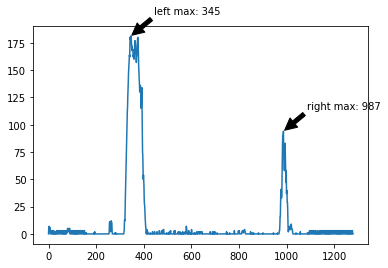

In [8]:
#Histogram along all the columns in the lower half of the image 
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
#show the peaks
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
plt.annotate('left max: '+str(leftx_base), xy=(leftx_base, histogram[leftx_base]), xytext=(leftx_base+100, histogram[leftx_base]+20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('right max: '+str(rightx_base), xy=(rightx_base, histogram[rightx_base]), xytext=(rightx_base+100, histogram[rightx_base]+20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

(720, 0)

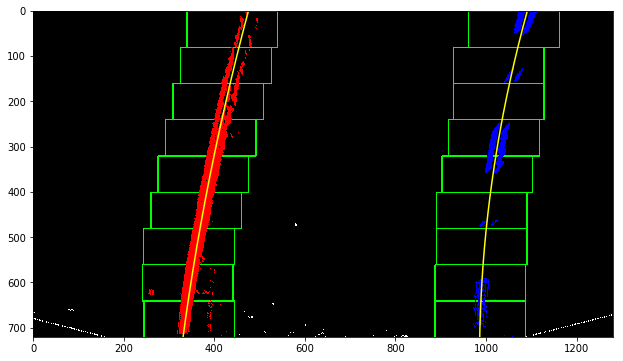

In [9]:
# Assuming you have created a warped binary image called "binary_warped"

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
binary_warped = binary_warped.astype(np.uint8)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):

    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(12, 6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [10]:
# measuring curvature and offest
def meas_curvature_offset(leftx, lefty, rightx, righty, img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the radii of curvature
    y_eval = img.shape[0] # radius at the bottom of the image
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = np.mean([left_curverad, right_curverad])
    
    # calculate offset
    image_centre = img.shape[1]/2 * xm_per_pix
    left_lane_bottom = (left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                        left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2])
    right_lane_bottom = (right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                         right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2])
    lane_width = right_lane_bottom - left_lane_bottom
    vehicle_centre = (right_lane_bottom + left_lane_bottom) / 2
    vehicle_offset = (image_centre - vehicle_centre)
    
    return left_fit_cr, right_fit_cr, left_curverad, right_curverad, curverad, vehicle_offset, lane_width

left_fit_cr, right_fit_cr, left_curverad, right_curverad, curverad, vehicle_offset, lane_width = meas_curvature_offset(leftx, lefty, rightx, righty, img)
# Now our radius of curvature is in meters
print('curvature left: {0:.1f} m, right:  {1:.1f} m, mean: {2:.1f} m'.format(left_curverad, right_curverad, curverad))
# Example values: 632.1 m    626.2 m
print('vehicle offset: {0:.2f} m'.format(vehicle_offset))
print('lane width: {0:.2f} m'.format(lane_width))

curvature left: 1787.7 m, right:  921.9 m, mean: 1354.8 m
vehicle offset: -0.10 m
lane width: 3.46 m


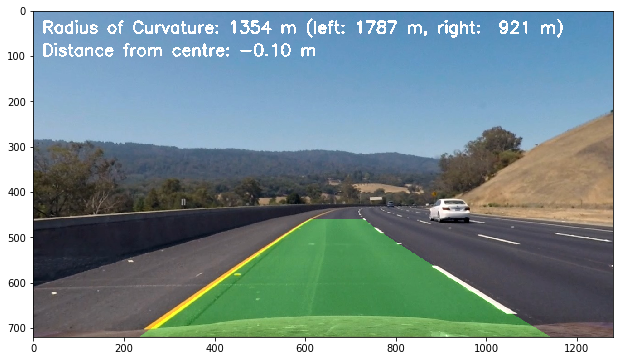

In [11]:
#result plotted back down onto the road
def draw_lane(binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, img, undist, left_curverad, right_curverad, curverad, vehicle_offset):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    cv2.putText(result, 'Radius of Curvature: {0:4d} m (left: {1:4d} m, right: {2:4d} m)'.format(int(curverad), int(left_curverad), int(right_curverad)), (20,50),
                 fontFace = 16, fontScale = 1.2, color=(255,255,255), thickness = 4)

    cv2.putText(result, 'Distance from centre: {:.2f} m'.format(vehicle_offset), (20,100), fontFace = 16, 
                fontScale = 1.2, color=(255,255,255), thickness = 4)
    return result

result = draw_lane(binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, img, undist, left_curverad, right_curverad, curverad, vehicle_offset)

plt.figure(figsize=(12, 6))
plt.imshow(result)

In [12]:
def find_lane(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, left_fit, right_fit

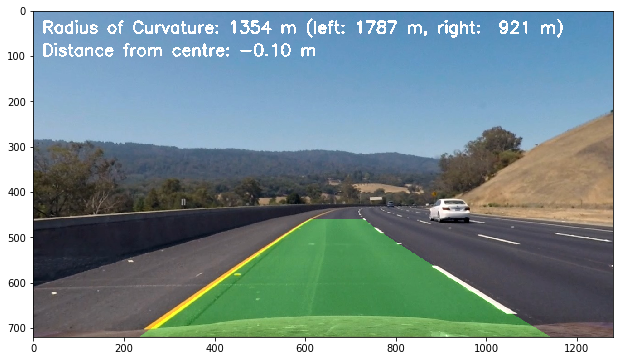

In [13]:
# image processing pipeline

def pipeline(img):
    binary_warped, undist = get_warped_binary(img, mtx, dist, src_pts, dst_pts)       
    leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, left_fit, right_fit = find_lane(binary_warped)    
    left_fit_cr, right_fit_cr, left_curverad, right_curverad, curverad, vehicle_offset, lane_width = meas_curvature_offset(leftx, lefty, rightx, righty, img)
    result = draw_lane(binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, img, undist, left_curverad, right_curverad, curverad, vehicle_offset)
    return result

#test pipeline
result = pipeline(img)
plt.figure(figsize=(12, 6))
plt.imshow(result)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# video processing
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
output_file_name = 'project_video_processed.mp4'
%time processed_clip.write_videofile(output_file_name, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:10<00:00,  4.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 4min 12s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file_name))

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [17]:
left_line = Line()
right_line = Line()

In [18]:
# Skip the sliding windows step once you know where the lines are
def find_lane_skip_sliding(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx 

In [23]:
def sanity_check(img, left_fit_cr, right_fit_cr, left_curverad, right_curverad):
    # Check curverad. Should be more than 300 m on highway
    if left_curverad < 300 or right_curverad < 300:
        return False
    
    # Check lane width at 10 y positions. Should be more than 3 m
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    for y_pix in range(0,img.shape[0], img.shape[0]//10):
        left_lane_xm =  (left_fit_cr[0]  * (y_pix * ym_per_pix) ** 2 + 
                         left_fit_cr[1]  * (y_pix * ym_per_pix) + left_fit_cr[2])
        right_lane_xm = (right_fit_cr[0] * (y_pix * ym_per_pix) ** 2 + 
                         right_fit_cr[1] * (y_pix * ym_per_pix) + right_fit_cr[2])
        lane_width = right_lane_xm - left_lane_xm
        if lane_width < 3.0 or lane_width > 4.0:
            return False
            
    return True

sanity = sanity_check(img, left_fit_cr, right_fit_cr, left_curverad, right_curverad)
print('sanity =', sanity)

sanity = True


In [28]:
# improved pipeline
def pipeline_improved(img, num_avg = 5):
    binary_warped, undist = get_warped_binary(img, mtx, dist, src_pts, dst_pts)   
    if (left_line.detected and right_line.detected):
        leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx = find_lane_skip_sliding(binary_warped, left_line.current_fit, right_line.current_fit)    
    else:
        leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, left_fit, right_fit = find_lane(binary_warped)
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        
    left_fit_cr, right_fit_cr, left_curverad, right_curverad, curverad, vehicle_offset, lane_width = meas_curvature_offset(leftx, lefty, rightx, righty, img)
    # sanity check
    if(sanity_check(img, left_fit_cr, right_fit_cr, left_curverad, right_curverad) == True):
        left_line.detected = True
        left_line.recent_xfitted.append(left_fitx)
        if len(left_line.recent_xfitted) > num_avg:
            left_line.recent_xfitted.pop(0)
        left_line.bestx = np.mean(left_line.recent_xfitted, axis=0) 
        left_line.radius_of_curvature = left_curverad
            
        right_line.detected = True 
        right_line.recent_xfitted.append(right_fitx)
        if len(right_line.recent_xfitted) > num_avg:
            right_line.recent_xfitted.pop(0)
        right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        right_line.radius_of_curvature = right_curverad
    else:
        left_line.detected = False
        right_line.detected = False
        # use old data
        left_fitx = left_line.bestx
        right_fitx = right_line.bestx
        left_curverad = left_line.radius_of_curvature
        right_curverad = right_line.radius_of_curvature
        curverad = np.mean([left_curverad, right_curverad])
       
    result = draw_lane(binary_warped, left_fitx, right_fitx, ploty, perspective_Minv, img, undist, left_curverad, right_curverad, curverad, vehicle_offset)
    return result

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# video processing
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(pipeline_improved)
output_file_name = 'project_video_processed_improved.mp4'
%time processed_clip.write_videofile(output_file_name, audio=False)

[MoviePy] >>>> Building video project_video_processed_improved.mp4
[MoviePy] Writing video project_video_processed_improved.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:00<00:00,  5.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed_improved.mp4 

Wall time: 4min 2s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file_name))